In [1]:
cd /workspace

/workspace


In [2]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import scvi.data
import scarches.dataset 
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(4,4), facecolor='white')
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [5]:
adata_all = sc.read('data/multispecies_concat_pp.h5ad')
adata_all.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 5414 × 7974
    obs: 'sample', 'species'
    var: 'gene_ids', 'Orig_VarNames'>

In [6]:
condition_key = 'sample'
cell_type_key = 'species'
target_conditions = ['rat39_3ac']

vae_epochs = 150
scanvi_epochs = 50
surgery_epochs = 150

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [7]:
set(adata_all.obs.species)

{'human', 'rat'}

In [8]:
set(adata_all.obs['sample'])

{'rat11_1a', 'rat11_2a', 'rat11_2b', 'rat39_3ac', 'rat39_3b'}

In [9]:
adata = adata_all.raw.to_adata()
adata.var_names_make_unique()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
set(source_adata.obs.species)

{'human', 'rat'}

In [11]:
set(source_adata.obs['sample'])

{'rat11_1a', 'rat11_2a', 'rat11_2b', 'rat39_3b'}

In [12]:
set(target_adata.obs.species)

{'human', 'rat'}

In [13]:
set(target_adata.obs['sample'])

{'rat39_3ac'}

In [14]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["sample"]                                              
INFO     Using labels from adata.obs["species"]                                              
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4103 cells, 31872 vars, 4 batches,
         2 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [15]:
source_adata

AnnData object with n_obs × n_vars = 4103 × 31872
    obs: 'sample', 'species', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'

In [16]:
set(source_adata.obs['_scvi_batch'])

{0, 1, 2, 3}

In [17]:
vae = sca.models.SCANVI(
    source_adata,
    "Desconocido",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [18]:
print("Labelled Indices: ", len(vae._labeled_indices))
print("Unlabelled Indices: ", len(vae._unlabeled_indices))

Labelled Indices:  4103
Unlabelled Indices:  0


In [19]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

INFO     Training Unsupervised Trainer for 150 epochs.                                       
INFO     Training SemiSupervised Trainer for 50 epochs.                                      
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 400 epochs                                                            
Training...:  83%|████████▎ | 124/150 [47:48<03:01,  6.98s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  83%|████████▎ | 124/150 [47:56<10:03, 23.19s/it]
INFO     Training is still in

In [20]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["species"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["sample"] = source_adata.obs[condition_key].tolist()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
... storing 'species' as categorical
... storing 'sample' as categorical


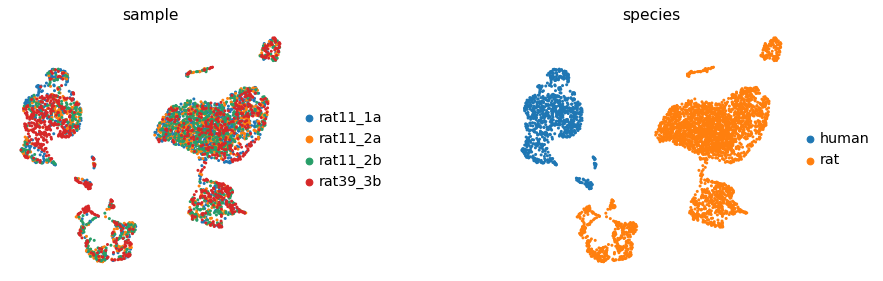

In [21]:
sc.pp.neighbors(reference_latent, n_neighbors=10)
sc.tl.leiden(reference_latent, resolution = 0.2)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['sample', 'species'],
           frameon=False,
           wspace=0.6,
           )

In [22]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.species)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 1.0


In [23]:
reference_latent


AnnData object with n_obs × n_vars = 4103 × 10
    obs: 'species', 'sample', 'leiden', 'predictions'
    uns: 'neighbors', 'leiden', 'umap', 'sample_colors', 'species_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [24]:
set(reference_latent.obs.predictions)


{'human', 'rat'}

In [25]:
set(reference_latent.obs.species)

{'human', 'rat'}

In [26]:
set(reference_latent.obs['sample'])

{'rat11_1a', 'rat11_2a', 'rat11_2b', 'rat39_3b'}

In [27]:
ref_path = 'models/vae'
vae.save(ref_path, overwrite=True)

In [28]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1311 cells, 31872 vars, 5 batches,
         2 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Labelled Indices:  0
Unlabelled Indices:  1311


In [29]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 150 epochs.                                     
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 150/150 [54:12<00:00, 21.68s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  874 s. / 150 epochs                                                 


In [30]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['species'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['sample'] = target_adata.obs[condition_key].tolist()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
... storing 'species' as categorical
... storing 'sample' as categorical


<Figure size 320x320 with 0 Axes>

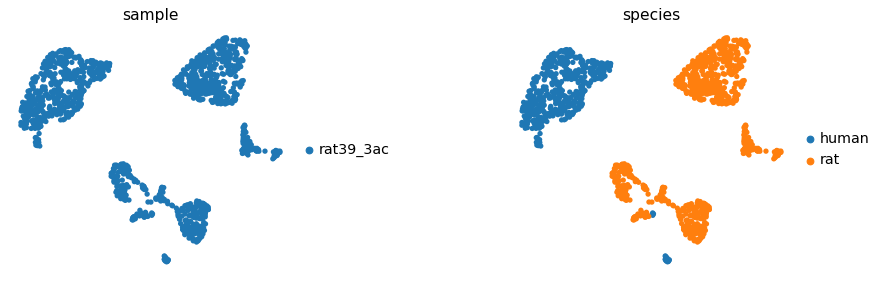

In [31]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["sample", "species"],
    frameon=False,
    wspace=0.6,
)

In [32]:
surgery_path = 'models/surgery_model'
model.save(surgery_path, overwrite=True)

In [33]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.species)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 1.0


In [34]:
set(query_latent.obs.species)

{'human', 'rat'}

Text(0, 0.5, 'Observed')

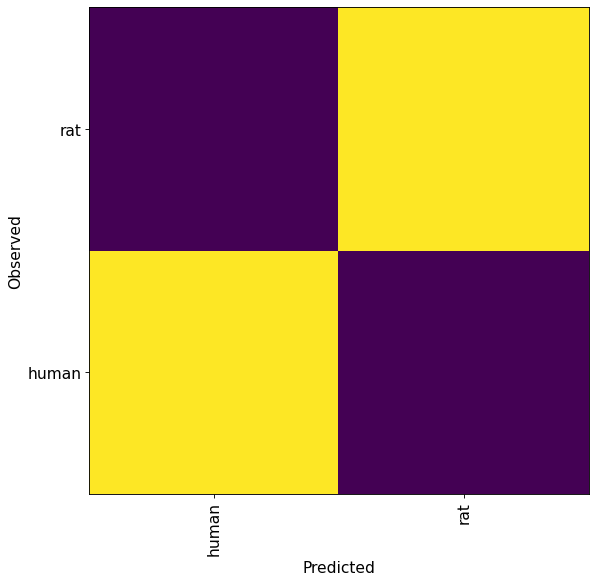

In [35]:
df = query_latent.obs.groupby(["species", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [36]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['species'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['sample'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 5414 cells, 31872 vars, 5 batches,
         2 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
... storing 'species' as categorical
... storing 'sample' as categorical


<Figure size 320x320 with 0 Axes>

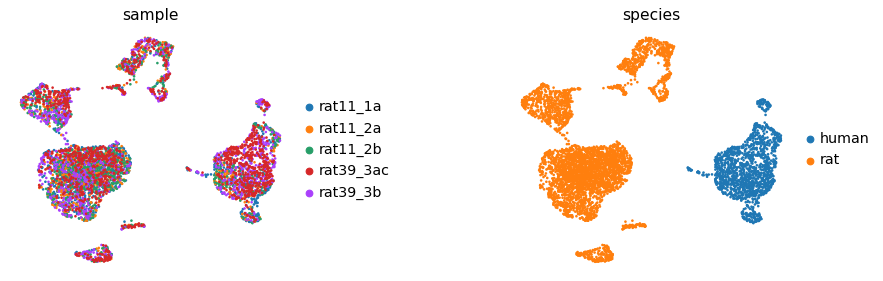

In [37]:

sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent, resolution= 0.2)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["sample", "species"],
    frameon=False,
    wspace=0.6,
)

In [38]:
full_latent.obs['predictions'] = model.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.species)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 1.0


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

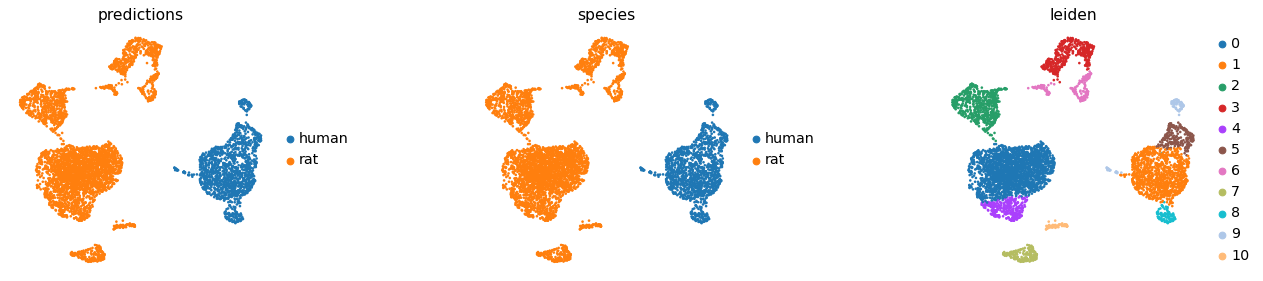

In [39]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent, resolution = 0.2)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["predictions", "species", "leiden"],
    frameon=False,
    wspace=0.6,
)

In [41]:
full_latent

AnnData object with n_obs × n_vars = 5414 × 10
    obs: 'species', 'sample', 'leiden', 'predictions'
    uns: 'neighbors', 'leiden', 'umap', 'sample_colors', 'species_colors', 'predictions_colors', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [40]:
full_latent.write('data/full_latent_species.h5ad')